# CBIR CON CNN

In [14]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

from keras.applications import VGG16
from keras.models import Model
from keras.applications.vgg16 import preprocess_input

In [15]:
n_imgs = 100
carpetas = ["autobus-n04487081", "clavos-n03804744", "coche-n02814533", "collarin-n03814639", "desatascador-n03970156",
         "gatos-n02123394", "mono-n02480495", "puentes-n04532670", "silla-n04099969", "perro-n02099601", 
            "pato-n01855672", "pizza-n07873807", "mar-n09428293", "ipod-n03584254", "platano-n07753592", "mascara_gas-n03424325", 
            "pajarita-n02883205", "mosca-n02190166", "helado-n07615774", "canon-n02950826"]
len(carpetas)

20

In [16]:
def get_images_path(carpetas, n_imgs):
    images_path = {}
    for carpeta in carpetas:
        for i in range(n_imgs):
            images_path[(carpeta[-7:], str(i))] = f'./dataset/{carpeta}/{carpeta[-9:]}_{str(i)}.JPEG'
    return images_path #Devuelve un diccionario en el que la clave es (carpeta, id), y los valores los paths

In [17]:
images_path = get_images_path(carpetas, n_imgs)
len(images_path)

2000

In [18]:
def display_n_similar(sorted_indexes, n):
    if n <= 0:
        print("El valor de n debe ser mayor que 0.")
        return

    if n > len(sorted_indexes):
        print(f"Solo hay {len(sorted_indexes)} imágenes en la lista. Mostrando todas.")
        n = len(sorted_indexes)
    fig, axs = plt.subplots(1, n, figsize=(15,15))
    for i in range(n):
        n_carpeta = (sorted_indexes[i][0])
        n_img = (sorted_indexes[i][1])
        path = images_path[(n_carpeta, n_img)]
        im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        axs[i].imshow(im)
        axs[i].axis('off')
        titulo = f'{n_carpeta}_{n_img}'
        axs[i].set_title(titulo)
        

    plt.show()

In [19]:
base_model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.layers[-1].output)

In [20]:
if os.path.exists('CNN_matrix.npy'):
    caracteristics = np.load('CNN_matrix.npy')
else:
    caracteristics = np.empty((0,25090))
    for idx in images_path:
        im = cv2.cvtColor(cv2.imread(images_path[idx]), cv2.COLOR_BGR2RGB)
        # Redimensionar la imagen al tamaño requerido por el modelo
        target_size = (224, 224)
        im = cv2.resize(im, target_size)
        # Agregar una dimensión
        im = np.expand_dims(im, axis=0)
        # Normalizar la imagen
        im = preprocess_input(im)

        # Extraer las características de la imagen
        caracteristics_img = model.predict(im, verbose=0)
        caracteristics_flat = caracteristics_img.reshape(1, -1)
        caracteristics_flat = np.insert(caracteristics_flat, 0, idx[1], axis=1)
        caracteristics_flat = np.insert(caracteristics_flat, 0, idx[0], axis=1)
        caracteristics =  np.vstack([caracteristics, caracteristics_flat])
    np.save('CNN_matrix', caracteristics)

In [21]:
caracteristics.shape

(2000, 25090)

In [22]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean')

caracteristics_train = caracteristics[:, 2:]
knn.fit(caracteristics_train)

NearestNeighbors(metric='euclidean')

1/1 [==============================] - 0s 204ms/step


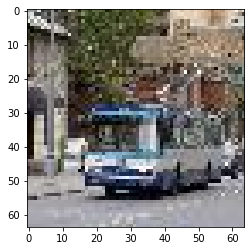

In [25]:
new_image_path = list(images_path.values())[random.randrange(0, len(carpetas)*n_imgs - 1)]
new_img = cv2.cvtColor(cv2.imread(new_image_path), cv2.COLOR_BGR2RGB)
plt.imshow(new_img)
# Redimensionar la imagen al tamaño requerido por el modelo
target_size = (224, 224)
new_img = cv2.resize(new_img, target_size)
# Agregar una dimensión
new_img = np.expand_dims(new_img, axis=0)
# Normalizar la imagen
new_img = preprocess_input(new_img)

# Extraer las características de la imagen
caracteristics_img = model.predict(new_img)
caracteristics_flat = caracteristics_img.reshape(1, -1)
distance, indice = knn.kneighbors(caracteristics_flat, n_neighbors=5)

ids = []
for idx in indice[0]:
        carpeta = str(int(caracteristics[idx,0]))
        num_img = str(int(caracteristics[idx,1]))
        ids.append((carpeta, num_img))

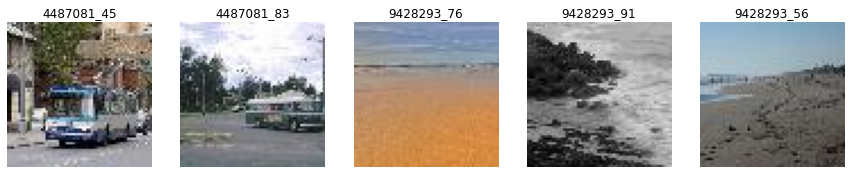

In [26]:
display_n_similar(ids, 5)